<a href="https://colab.research.google.com/github/Kacperw14/simulide/blob/master/sieci_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/akopij70/Dataset.git

fatal: destination path 'Dataset' already exists and is not an empty directory.


In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import tarfile
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [ ]:
base_dir = './Dataset/flowers'
os.listdir(base_dir)

['dandelion', 'tulip', 'rose', 'daisy', 'sunflower']

In [ ]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
dataset = ImageFolder(base_dir, transform=transformer)

In [ ]:
len(dataset)

4317

In [ ]:
validationSetSize = 600
trainingSetSize = len(dataset) - validationSetSize

In [ ]:
def showExample(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  daisy (0)


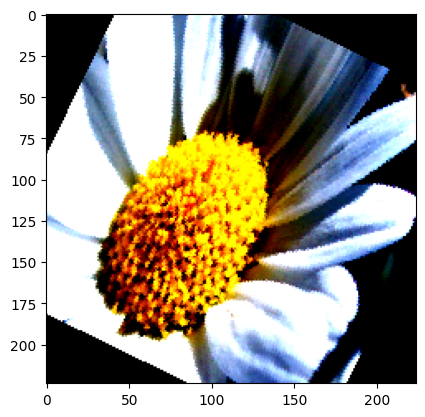

In [ ]:
showExample(*dataset[1])

In [ ]:
trainDataLoader = DataLoader(trainDataSet, batch_size = 32, shuffle=True)
valDataLoader = DataLoader(valDataSet, batch_size = 32)
testDataLoader = DataLoader(testDataSet, batch_size = 32)

Label:  rose (2)


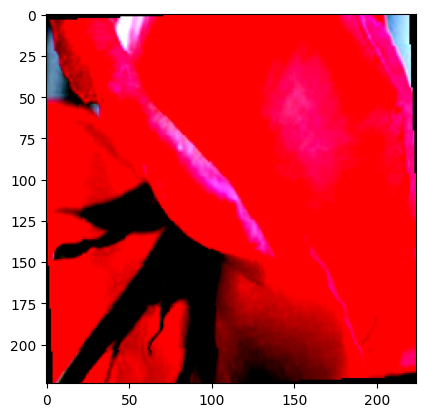

In [ ]:
showExample(*trainDataSet[1])

In [ ]:
print(dataset.classes)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


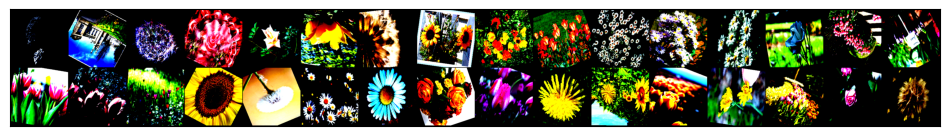

In [ ]:
def showBatch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

showBatch(trainDataLoader)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
class FlowerClassificationModel(nn.Module):
    def trainingStep(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
    def forward(self, xb):
        return self.network(xb)
        
    #def forward(self, xb):
     #   return self.network(xb)
    
    def validationStep(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)     
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validationEpochEnd(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epochEnd(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
model = FlowerClassificationModel()
model

FlowerClassificationModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [ ]:
for images, labels in trainDataLoader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 224, 224])
out.shape: torch.Size([32, 5])
out[0]: tensor([-0.0201,  0.0346,  0.0515,  0.0047,  0.0106],
       grad_fn=<SelectBackward0>)


In [ ]:
@torch.no_grad()
def evaluate(model, valLoader):
    model.eval()
    outputs = [model.validationStep(batch) for batch in valLoader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, trainLoader, valLoader, optFunc=torch.optim.SGD):
    history = []
    optimizer = optFunc(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        trainLosses = []
        for batch in trainLoader:
            loss = model.trainingStep(batch)
            trainLosses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_Grad()
        # Validation phase
        result = evaluate(model, valLoader)
        result['trainLoss'] = torch.stack(trainLosses).mean().item()
        model.epochEnd(epoch, result)
        history.append(result)
    return history

In [88]:
def getDefaultDevice():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def toDevice(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [toDevice(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield toDevice(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = getDefaultDevice()

In [ ]:
trainDataLoader = DeviceDataLoader(trainDataLoader, device)
valDataLoader = DeviceDataLoader(valDataLoader, device)
toDevice(model, device);

In [ ]:
model = toDevice(FlowerClassificationModel(), device)
evaluate(model, valDataLoader)

In [ ]:
numEpochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(numEpochs, lr, model, trainDataLoader, valDataLoader, optFunc)